In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Layer, Input, Dense, Flatten, Conv2D, MaxPool2D
import matplotlib.pyplot as plt


input_img_dir = 'app_data/input_images'
verification_img_dir = 'app_data/verification_images'
model_name = 'model/siamesemodel_xhlayer_224_dataaugmented_epoch50_115samples_b16.h5'

verification_threshold = 0.6

# Image preprocessing
def preprocessing(file_path):
    byte_img = cv2.imread(file_path)
    img = cv2.cvtColor(byte_img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0

    return img


# Caluclate L1 (Manhattan) Distance
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


'''# Define CNN for embedding
def embedding_model():
    inp = Input(shape=(225, 225, 3))
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPool2D(64, (2, 2), padding='same')(c1)
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPool2D(64, (2, 2), padding='same')(c2)
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPool2D(64, (2, 2), padding='same')(c3)
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    embedding_model = keras.Model(inputs=[inp], outputs=[d1], name='embedding')
    return embedding_model


# Compare similarity using two pipelines
def siamese_model(embedding):
    # define two input tensors
    input_image = Input(name='input_img', shape=(225, 225, 3))
    validation_image = Input(name='validation_img', shape=(225, 225, 3))

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Apply dense layer with single neuron for similarity classifier
    # Sigmoid to compress single input to 0 and 1 as output
    classifier = Dense(1, activation='sigmoid')(distances)

    siamese_model = keras.Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNeuralNetwork')
    return siamese_model'''


# Load the input images for verification
def load_input_images(directory):
    input_classes = os.listdir(directory)

    input_imgs = {}
    for input_class in input_classes:
        input_class_dir = os.path.join(directory, input_class)
        # Append key to the dictionary
        input_imgs[input_class] = []

        for input_img in os.listdir(input_class_dir):
            input_img_dir = os.path.join(input_class_dir, input_img)
            # Append image directories as values
            input_imgs[input_class].append(preprocessing(input_img_dir))

    return input_imgs


# Load database images for verification
def load_verification_images(directory, max_img_ref=20):
    verification_classes = os.listdir(directory)

    verification_imgs = {}
    for verification_class in verification_classes:
        verification_class_dir = os.path.join(directory, verification_class)
        verification_imgs[verification_class] = []

        count = 0
        for verification_img in os.listdir(verification_class_dir):
            if count >= max_img_ref:
                break
            verification_img_dir = os.path.join(verification_class_dir, verification_img)
            verification_imgs[verification_class].append(preprocessing(verification_img_dir))
            count += 1

    return verification_imgs


# Verifies input images against verification images using a Siamese model.
def verify_face(siamese_model, faces_input, faces_verification, verification_threshold):
    y_true = []
    y_pred = []

    for input_class in faces_input:
        for face_input in faces_input[input_class]:
            for face_verification in faces_verification[input_class]:
                result = siamese_model.predict([np.expand_dims(face_input, axis=0),
                                                np.expand_dims(face_verification, axis=0)])
                y_true.append(input_class)

                if result[0][0] > verification_threshold:
                    y_pred.append(input_class)
                    print(f"Similarity Score: {result[0][0]}")
                    print("Verification Successful")
                else:
                    y_pred.append('Z - Unknown')
                    print(f"Similarity Score: {result[0][0]}")
                    print("Verification Failed")

                plt.figure(figsize=(10, 8))
                plt.subplot(1, 2, 1)
                plt.imshow(face_input)
                plt.title("Input Image")
                plt.subplot(1, 2, 2)
                plt.imshow(face_verification)
                plt.title("Verification Image")
                plt.show()

    return y_true, y_pred


# load model with custom L1Dist layer
siamese_model = load_model(model_name, custom_objects = {'L1Dist': L1Dist})
#siamese_model.summary()
faces_input = load_input_images(input_img_dir)
faces_verification = load_verification_images(verification_img_dir)
y_true, y_pred = verify_face(siamese_model, faces_input, faces_verification, verification_threshold)


                    precision    recall  f1-score   support

 Alec Yong Zi Chun       1.00      0.95      0.97        20
Amos Liew Chee Han       1.00      0.95      0.97        20
      Chai Wen Xin       1.00      0.75      0.86        20
          Chempaka       1.00      0.95      0.97        20
           Farisha       1.00      1.00      1.00        20
       Lan Yi Xian       1.00      1.00      1.00        20
    Loke Yan Kuang       1.00      0.95      0.97        20
      Tan Chu Heng       1.00      0.95      0.97        20
     Tan Ming Fang       1.00      1.00      1.00        20
     Tan Xing Hong       1.00      1.00      1.00        20
       Yen Kin Sam       1.00      1.00      1.00        20
       Z - Unknown       0.00      0.00      0.00         0

          accuracy                           0.95       220
         macro avg       0.92      0.88      0.89       220
      weighted avg       1.00      0.95      0.98       220



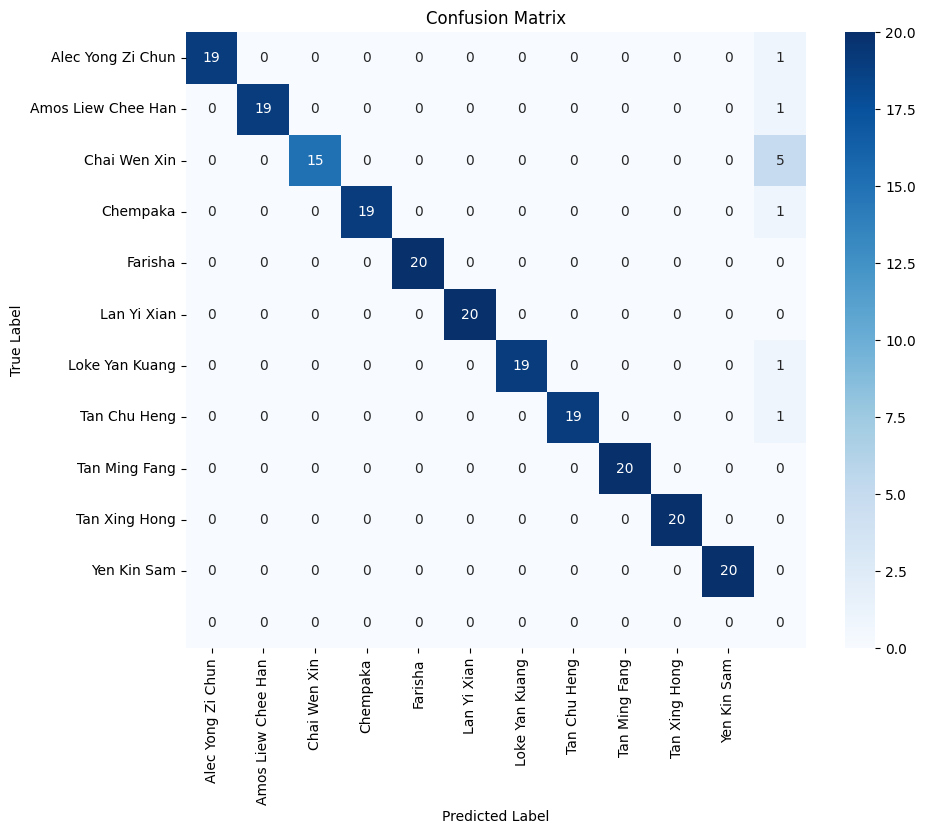

In [2]:
import warnings
import seaborn as sns
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import classification_report, confusion_matrix


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

    # Print classification report
    print(classification_report(y_true, y_pred, zero_division=0))
    confusion_mat = confusion_matrix(y_true, y_pred)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Display confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()